In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as mtick


from epitools import between_p, within_p

In [34]:
VOTES_POLLING = 0
RATE_THRESHOLD = 0
output = []

for country, year, election in [
    ("France", 2002, "first_round"),
    ("France", 2007, "first_round"),
    ("France", 2012, "first_round"),
    ("France", 2017, "first_round"),
    ("France", 2022, "first_round"),
    ("United States", 2000, "first_round"),
    ("United States", 2004, "first_round"),
    ("United States", 2008, "first_round"),
    ("United States", 2012, "first_round"),
    ("United States", 2016, "first_round"),
    ("United States", 2020, "first_round"),
    ("Chile", 2013, "first_round"),
    ("Chile", 2017, "first_round"),
    ("Chile", 2021, "first_round")
]:
    df = pd.read_csv(f"data_output/{country}/{year}_{election}.csv.gz")
    ee = df.groupby("polling_id").agg({"value": "sum"})
    dd = df.groupby("candidate").agg({"value": "sum"})
    dd["rate"] = dd.apply(lambda x: x/x.sum())

    if country == "United States":
        values = list(dd[dd["rate"] > 0.1].index.unique())
    else:
        values = list(dd[dd["rate"] > RATE_THRESHOLD].index.unique())

    df = df[df["candidate"].isin(values)].copy()

    tt = df.groupby(["polling_id", "candidate"]).agg({"value": "sum"})
    tt["rate"] = tt.groupby(level=[0], group_keys=False).apply(lambda x: x/x.sum())
    tt = tt.reset_index()

    df = tt.copy()

    N = len(df["candidate"].unique())

    df_a = between_p(df)
    df_b = within_p(df)

    df = pd.merge(df_a, df_b, on=["candidate"])

    output.append({
        "country": country,
        "year": year,
        "N": N,
        "value": np.sum((df["value_x"] + df["value_y"])),
        "between": np.sum(df["value_x"]),
        "within": np.sum(df["value_y"])
    })

df = pd.DataFrame(output)
df

,country,year,N,value,between,within
0,France,2002,16,0.954331,0.924872,0.029458
1,France,2007,12,0.909241,0.880818,0.028423
2,France,2012,10,0.897197,0.862963,0.034233
3,France,2017,11,0.906764,0.874921,0.031842
4,France,2022,12,0.917522,0.881055,0.036467
5,United States,2000,2,1.000354,0.790305,0.210049
6,United States,2004,2,0.998311,0.780116,0.218195
7,United States,2008,2,0.991714,0.764023,0.227691
8,United States,2012,2,0.997476,0.749278,0.248198
9,United States,2016,2,0.999022,0.704033,0.294989


In [45]:
(0.917522 -0.906764)/0.917522

0.01172505945361521

In [35]:
def get_data_from_worldbank(PATH, measure_name):
    output_df = pd.read_excel(PATH, header=3)
    output_df = output_df[["Country Name"] + list(map(str, list(range(1960, 2021 + 1))))]
    output_df = output_df.rename(columns={"Country Name": "country"})
    output_df = output_df.melt(id_vars=["country"], var_name="year", value_name=measure_name)
    output_df = output_df.dropna().reset_index(drop=True)
    output_df["year"] = output_df["year"].astype(int)

    custom_df_2022 = output_df[output_df["year"] == 2021].copy()
    custom_df_2022["year"] = 2022
    return pd.concat([output_df, custom_df_2022])

In [36]:
df_gdp_per_capita = get_data_from_worldbank(
    "data_worldbank/API_NY.GDP.PCAP.PP.KD_DS2_en_excel_v2_4770533.xls", 
    measure_name="gdp_per_capita"
)
df_gdp_per_capita.tail()


,country,year,gdp_per_capita
7412,Samoa,2022,5534.126958
7413,Kosovo,2022,11884.179915
7414,South Africa,2022,13311.925699
7415,Zambia,2022,3236.788981
7416,Zimbabwe,2022,2115.144555


In [37]:
df_gini = get_data_from_worldbank(
    "data_worldbank/API_SI.POV.GINI_DS2_en_excel_v2_4770509.xls", 
    measure_name="gini"
)
df_gini.head()

,country,year,gini
0,Sweden,1967,34.0
1,United Kingdom,1969,33.7
2,Canada,1971,37.3
3,United Kingdom,1974,30.0
4,United States,1974,35.3


In [38]:
df_unemployment = get_data_from_worldbank(
    "data_worldbank/API_SL.UEM.TOTL.NE.ZS_DS2_en_excel_v2_4770856.xls", 
    measure_name="unemployment"
)
df_unemployment.head()

,country,year,unemployment
0,Japan,1960,1.7
1,United States,1960,5.5
2,Japan,1961,1.4
3,United States,1961,6.7
4,Japan,1962,1.3


In [39]:
df_population = get_data_from_worldbank(
    "data_worldbank/API_SP.POP.TOTL_DS2_en_excel_v2_4770385.xls", 
    measure_name="population"
)
df_population.tail()

,country,year,population
16395,Kosovo,2022,1786038.0
16396,"Yemen, Rep.",2022,32981641.0
16397,South Africa,2022,59392255.0
16398,Zambia,2022,19473125.0
16399,Zimbabwe,2022,15993524.0


In [40]:
df_rural_population = get_data_from_worldbank(
    "data_worldbank/API_SP.RUR.TOTL.ZS_DS2_en_excel_v2_4773326.xls", 
    measure_name="rural_population"
)
df_rural_population.tail()

,country,year,rural_population
16301,Samoa,2022,82.258
16302,"Yemen, Rep.",2022,61.454
16303,South Africa,2022,32.153
16304,Zambia,2022,54.808
16305,Zimbabwe,2022,67.697


In [41]:
df_model = df.copy()
for dt in [df_gdp_per_capita, df_gini, df_unemployment, df_population, df_rural_population]:
    df_model = pd.merge(dt, df_model, on=["country", "year"])
    
df_model.to_csv("test.csv")

In [42]:
df_model

,country,year,rural_population,population,unemployment,gini,gdp_per_capita,N,value,between,within
0,United States,2000,20.943,282162411.0,3.99,40.1,50175.738235,2,1.000354,0.790305,0.210049
1,United States,2004,20.243,292805298.0,5.53,40.3,52995.243085,2,0.998311,0.780116,0.218195
2,France,2007,22.379,64021737.0,8.01,32.4,43123.501133,12,0.909241,0.880818,0.028423
3,United States,2008,19.562,304093966.0,5.78,40.8,55433.676510,2,0.991714,0.764023,0.227691
4,France,2012,21.122,65662240.0,9.84,33.1,42789.051913,10,0.897197,0.862963,0.034233
5,United States,2012,18.881,313877662.0,8.07,40.9,55803.513510,2,0.997476,0.749278,0.248198
6,Chile,2013,12.754,17509925.0,6.20,45.8,24011.591014,9,0.877564,0.826001,0.051562
7,United States,2016,18.138,323071755.0,4.87,41.1,58972.900613,2,0.999022,0.704033,0.294989
8,Chile,2017,12.510,18368577.0,6.95,44.4,24546.912421,8,0.886493,0.836947,0.049546
9,France,2017,19.820,66918020.0,9.41,31.6,44577.064575,11,0.906764,0.874921,0.031842


IndexError: index 2 is out of bounds for axis 0 with size 2

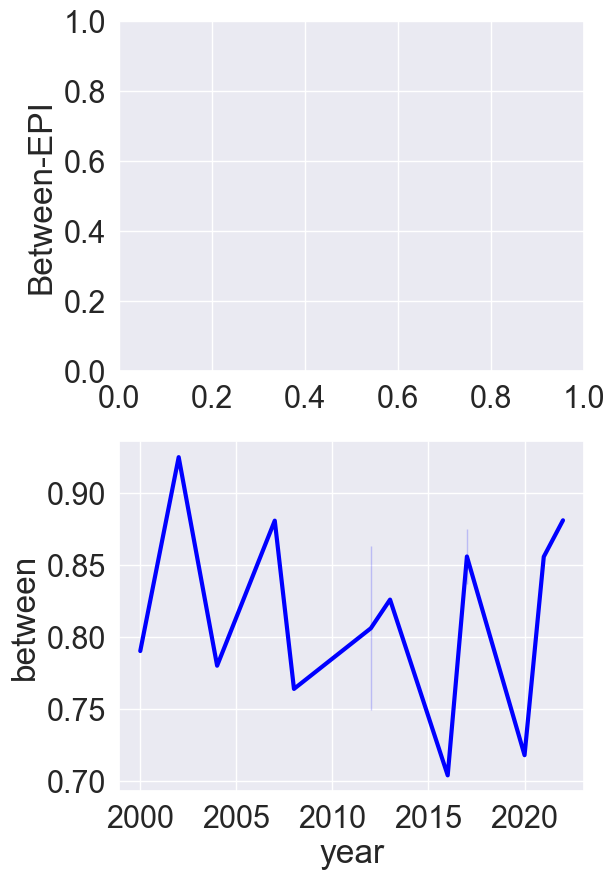

In [43]:
sns.set(font_scale=2)
data = df#[df["country"] == "France"]
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))

# sns.lineplot(x="year", y="value", color="blue", lw=3, data=data, ax=axs[0])
# axs[0].set_ylabel("EPI")
sns.lineplot(x="year", y="between", color="blue", lw=3, data=data, ax=axs[1])
axs[0].set_ylabel("Between-EPI")
sns.lineplot(x="year", y="within", color="blue", lw=3, data=data, ax=axs[2])
axs[1].set_ylabel("Within-EPI")

for i in range(3):
    ax = axs[i]
    # ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    ax.set_xlabel("")
    sns.despine()
fig.tight_layout()

In [ ]:
# df["alternative"] = df["between"] * df["within"]
# df

ValueError: Could not interpret value `alternative` for parameter `y`

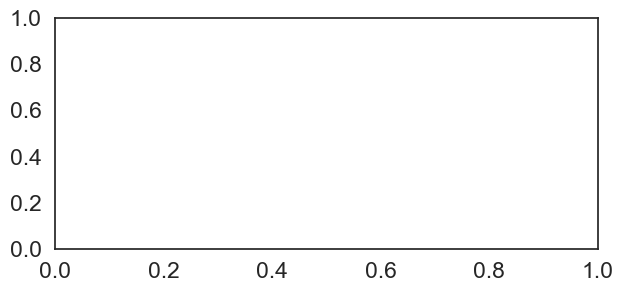

In [ ]:
sns.set(font_scale=1.5, style="white")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3))
linestyles = ["dotted", "dashed", "dashdot"]
palette = ["orange", "blue", "red"]
idx = 0
for i, data in df.groupby("country"):
    sns.lineplot(
        x="year", 
        y="alternative", 
        color=palette[idx], 
        linestyle=linestyles[idx],
        marker="o", 
        lw=2, 
        # hue="country", 
        data=data#[data["country"] == "United States"]
    )
    idx += 1
sns.despine()
ax.set_xlabel("")
ax.set_ylabel("EPI")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, frameon=False)
fig.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


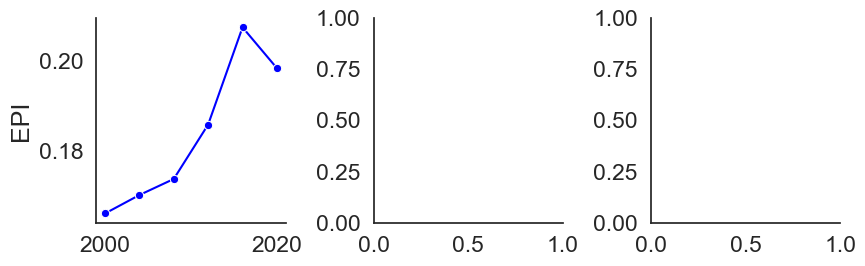

In [ ]:
sns.set(font_scale=1.5, style="white")
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
i = 0
for idx, tmp in df.groupby("country"):
    ax = axs[i]
    sns.lineplot(x="year", y="value", color="blue", marker="o", ax=ax, data=tmp)
    i += 1

    ax.legend(title="", frameon=False)
    ax.set_xlabel("")
    ax.set_ylabel("EPI")
    # plt.xlim([2000, 2023])

sns.despine()
fig.tight_layout()
# sns.scatterplot(x="year", y="value", s=75, hue="country", data=df)